In [1]:
"""Evaluate BARPA-R for CAT turbulence indices.
Use a reanalysis such as BARRA-R or ERA5 for the "truth"
Evaluate:
    - pdf of values using quantiles and KS test
    - spatial distribution
    - time series
"""

'Evaluate BARPA-R for CAT turbulence indices.\nUse a reanalysis such as BARRA-R or ERA5 for the "truth"\nEvaluate:\n    - pdf of values using quantiles and KS test\n    - spatial distribution\n    - time series\n'

In [22]:
import xarray as xr
import glob
import intake
import numpy as np
import seaborn as sns
from scipy import stats


import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [3]:
from plotting_maps.acs_plotting_maps import plot_acs_hazard_multi, plot_acs_hazard, plot_data, cmap_dict, regions_dict
from matplotlib import colors, cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

from dask.diagnostics import ProgressBar
# ProgressBar().register()

import dask
from dask.distributed import Client
client = Client(threads_per_worker=2, n_workers=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 1
Total threads: 2,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37939,Workers: 1
Dashboard: /proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:33711,Total threads: 2
Dashboard: /proxy/38551/status,Memory: 125.19 GiB
Nanny: tcp://127.0.0.1:34253,


In [4]:
mid_lat_slice = slice(-50,-25)
lon_slice = slice(90,195)
baseline_time_range = np.arange(1990,2009+1)

turbulence_index = "windspeed"
p95, p99, p999 = (62.835737276077246, 75.76162159729002, 88.1229062187195)

In [5]:
list_evaluation = ['evaluation_ERA5_r1i1p1f1', 
                   'evaluation_BARRA-R_r1i1p1f1']

list_historical = ['historical_ACCESS-CM2_r4i1p1f1', 
                   'historical_ACCESS-ESM1-5_r6i1p1f1',
                   'historical_CESM2_r11i1p1f1', 
                   'historical_CMCC-ESM2_r1i1p1f1',
                   'historical_EC-Earth3_r1i1p1f1', # not all years
                   'historical_MPI-ESM1-2-HR_r1i1p1f1',
                   'historical_NorESM2-MM_r1i1p1f1',
                  ]

In [6]:
# frequency = "monthly"
# run_filename_list = [f"/scratch/v46/gt3409/TMP_{turbulence_index}/TMP_{turbulence_index}-{frequency}-percentiles_AUS-15_{run}_BOM_BARPA-R_v1-r1_6hr.nc"
#                                     for run in list_evaluation + list_historical]
# ds = xr.open_mfdataset(run_filename_list,
#                                    concat_dim = "run",
#                                    combine="nested",
#                                    # chunks = {"run":1, 
#                                    #           "time":-1, 
#                                    #           # "lat":-1,
#                                    #           "lon":111, 
#                                    #           "quantile":-1},
#                                    preprocess = lambda ds: ds.sel({"lat":mid_lat_slice, 
#                                                                    "lon":lon_slice})\
#                                                              .astype("float32")\
#                                                              .mean(["lat", "lon"]),
#                       )
# ds = ds.load()

# ds.to_netcdf("/scratch/v46/gt3409/turbulence_AUSCAT/windspeed-monthly_percentiles_midlatbox.nc")
# ds

In [7]:
ds = xr.open_dataset("/scratch/v46/gt3409/turbulence_AUSCAT/windspeed-monthly_percentiles_midlatbox.nc")
ds.load()

<xarray.Dataset> Size: 868kB
Dimensions:    (run: 9, time: 240, quantile: 100)
Coordinates:
    pressure   int64 8B 250
  * quantile   (quantile) float64 800B 0.0 0.01 0.02 0.03 ... 0.97 0.98 0.99
  * time       (time) datetime64[ns] 2kB 1990-01-31 1990-02-28 ... 2009-12-31
  * run        (run) <U24 864B 'evaluation_ERA5_r1i1p1f1' ... 'historical_Nor...
Data variables:
    windspeed  (run, time, quantile) float32 864kB 4.765 6.812 ... 49.22 51.08

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _va

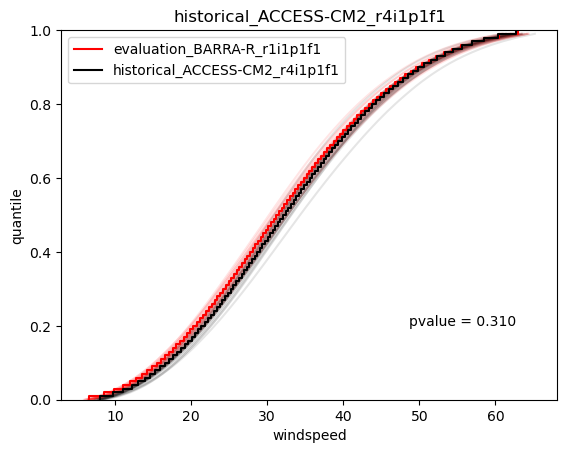

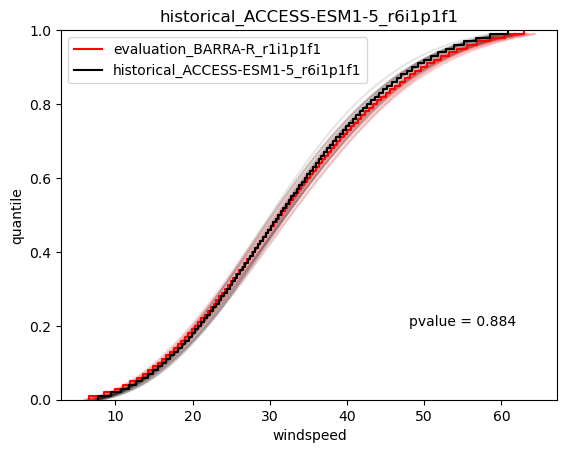

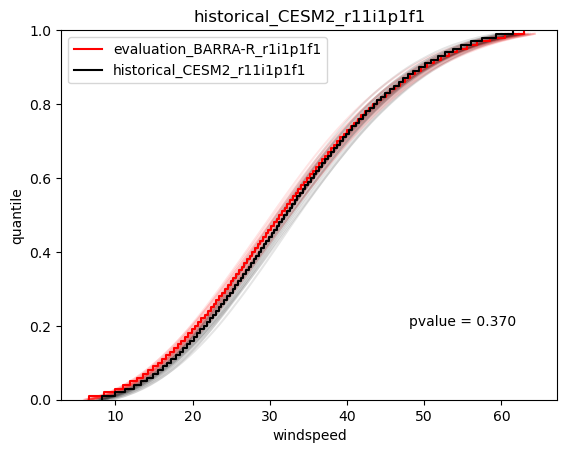

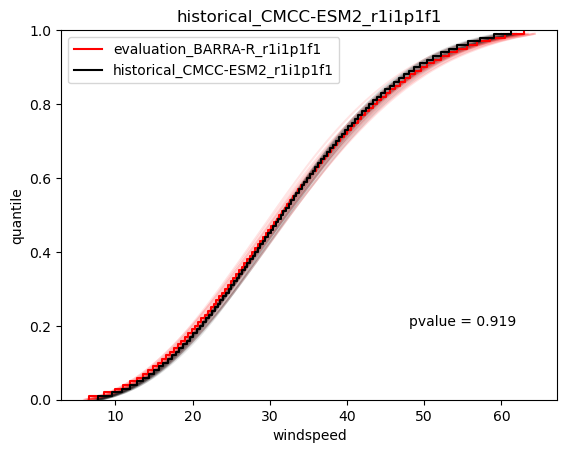

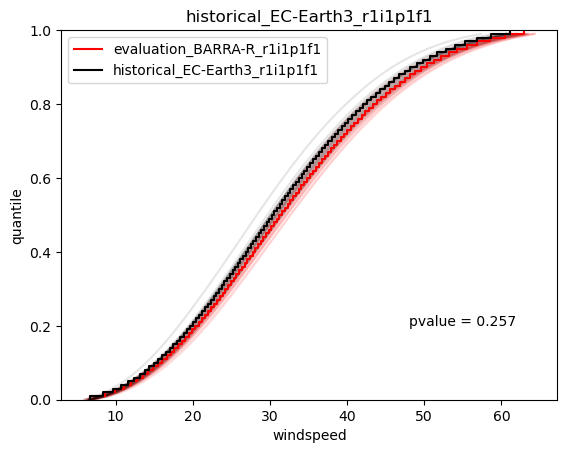

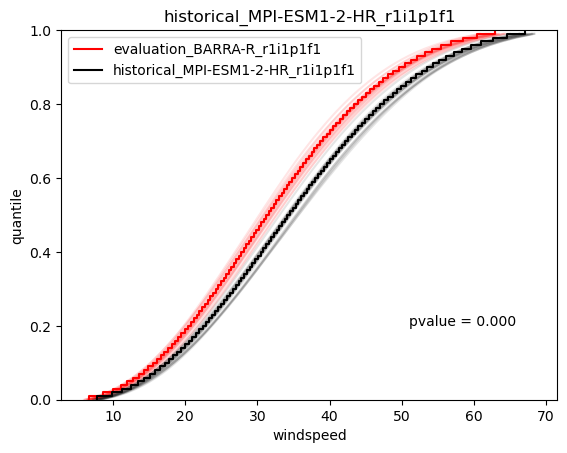

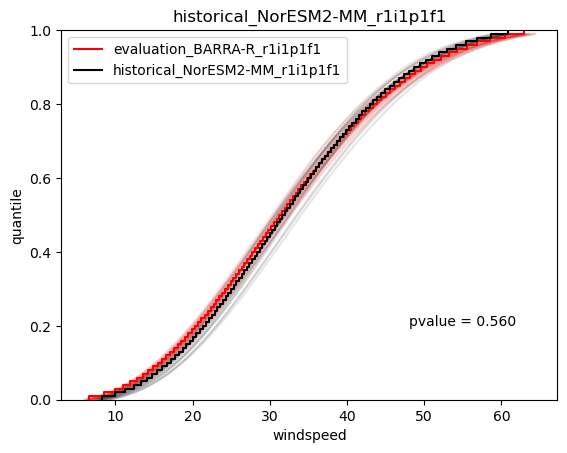

In [51]:
for run in list_historical:
    plt.figure()
    plt.title(run)
    evaluation = list_evaluation[1]
    for year in np.arange(1990,2009):
        sns.lineplot(data = ds.sel({"run":evaluation[:24]}).sel({"time":f"{year}"}).mean("time"), x="windspeed", y="quantile", color="r", alpha=0.1)
    for year in np.arange(1990,2009):
        sns.lineplot(data = ds.sel({"run":run[:24]}).sel({"time":f"{year}"}).mean("time"), x="windspeed", y="quantile", color="k", alpha=0.1)
    sns.ecdfplot(data = ds.sel({"run":evaluation[:24]}).mean("time")["windspeed"], color="r", label=evaluation)
    sns.ecdfplot(data = ds.sel({"run":run[:24]}).mean("time")["windspeed"], color="k", label=run)
    
    # calculate pvalue
    ks_statistic, pvalue = stats.ks_2samp(ds.sel({"run":evaluation[:24]}).resample({"time":"YE"}).mean()["windspeed"].values.flatten(),
                                          ds.sel({"run":run[:24]}).resample({"time":"YE"}).mean()["windspeed"].values.flatten(),)
    # print(f"{run}: pvalue {pvalue:.3f}, ks_stat = {ks_statistic}")
    # add pvalue to plot
    plt.text(x=0.7, y=0.2, s= f"pvalue = {pvalue:.3f}", transform = plt.gca().transAxes)
    plt.legend()
    

In [60]:
ds.sel({"run":evaluation[:24]}).where(ds.time.dt.month.isin([3]),drop=True)

<xarray.Dataset> Size: 9kB
Dimensions:    (time: 20, quantile: 100)
Coordinates:
    pressure   int64 8B 250
  * quantile   (quantile) float64 800B 0.0 0.01 0.02 0.03 ... 0.97 0.98 0.99
  * time       (time) datetime64[ns] 160B 1990-03-31 1991-03-31 ... 2009-03-31
    run        <U24 96B 'evaluation_BARRA-R_r1i1p'
Data variables:
    windspeed  (time, quantile) float32 8kB 4.973 6.911 8.153 ... 58.84 61.72

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _va

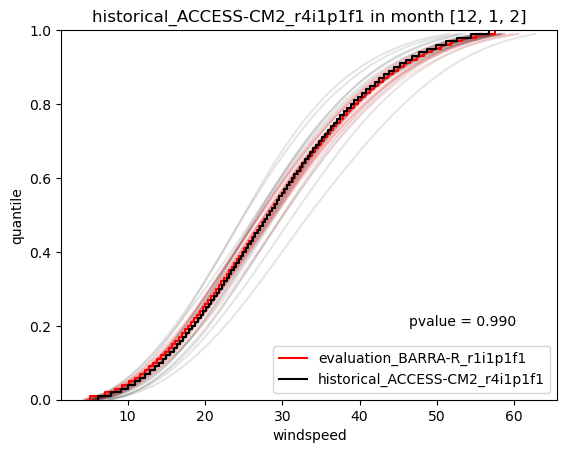

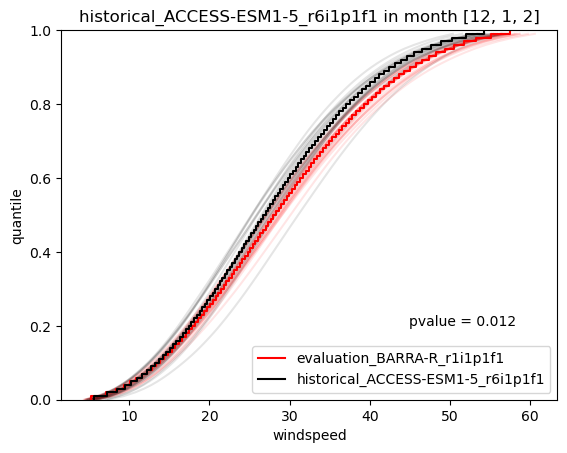

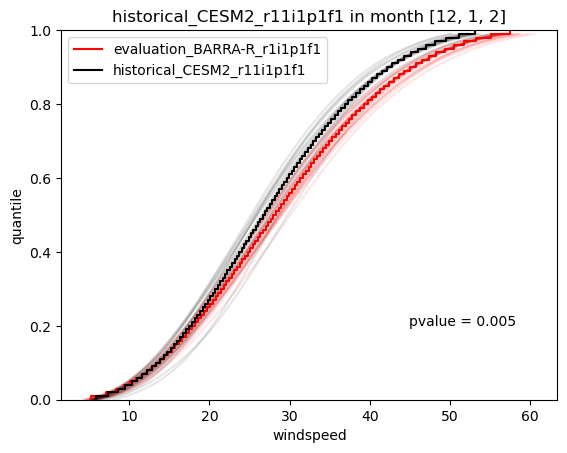

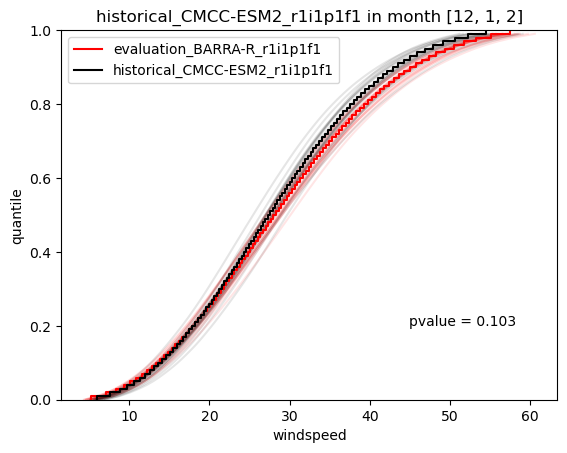

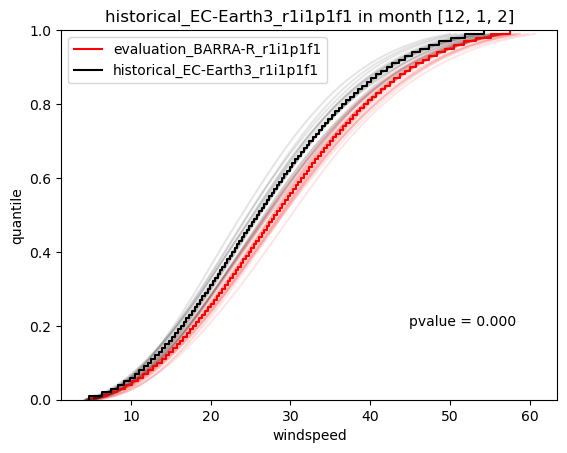

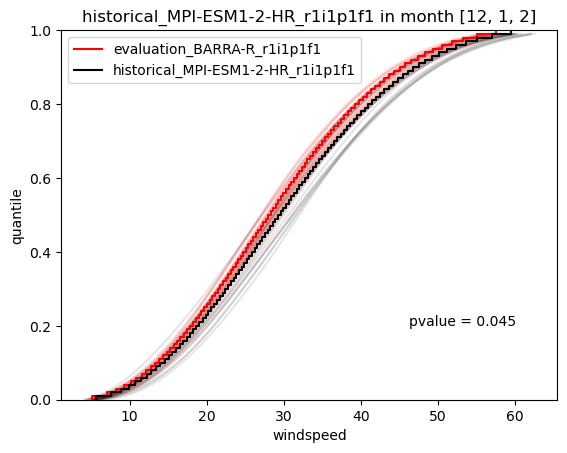

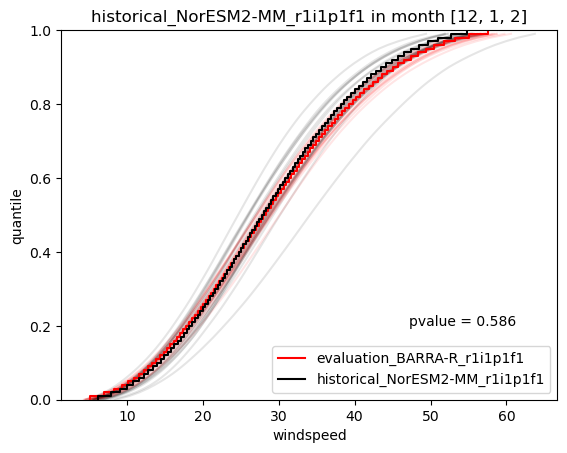

In [63]:
months = [12, 1,2]
for run in list_historical:
    plt.figure()
    plt.title(f"{run} in month {months}")
    evaluation = list_evaluation[1]
    for year in np.arange(1990,2009):
        sns.lineplot(data = ds.sel({"run":evaluation[:24]}).where(ds.time.dt.month.isin(months),drop=True).sel({"time":f"{year}"}).mean("time"), x="windspeed", y="quantile", color="r", alpha=0.1)
    for year in np.arange(1990,2009):
        sns.lineplot(data = ds.sel({"run":run[:24]}).where(ds.time.dt.month.isin(months),drop=True).sel({"time":f"{year}"}).mean("time"), x="windspeed", y="quantile", color="k", alpha=0.1)
    sns.ecdfplot(data = ds.sel({"run":evaluation[:24]}).where(ds.time.dt.month.isin(months),drop=True).mean("time")["windspeed"], color="r", label=evaluation)
    sns.ecdfplot(data = ds.sel({"run":run[:24]}).where(ds.time.dt.month.isin(months),drop=True).mean("time")["windspeed"], color="k", label=run)
    
    # calculate pvalue
    ks_statistic, pvalue = stats.ks_2samp(ds.sel({"run":evaluation[:24]}).where(ds.time.dt.month.isin(months),drop=True).resample({"time":"YE"}).mean()["windspeed"].values.flatten(),
                                          ds.sel({"run":run[:24]}).where(ds.time.dt.month.isin(months),drop=True).resample({"time":"YE"}).mean()["windspeed"].values.flatten(),)
    # print(f"{run}: pvalue {pvalue:.3f}, ks_stat = {ks_statistic}")
    # add pvalue to plot
    plt.text(x=0.7, y=0.2, s= f"pvalue = {pvalue:.3f}", transform = plt.gca().transAxes)
    plt.legend()
    

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _va

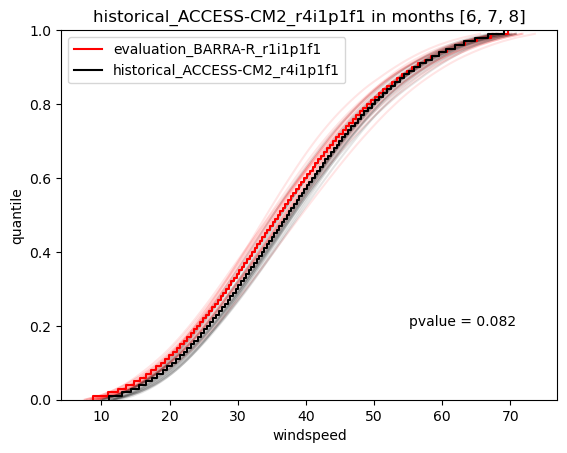

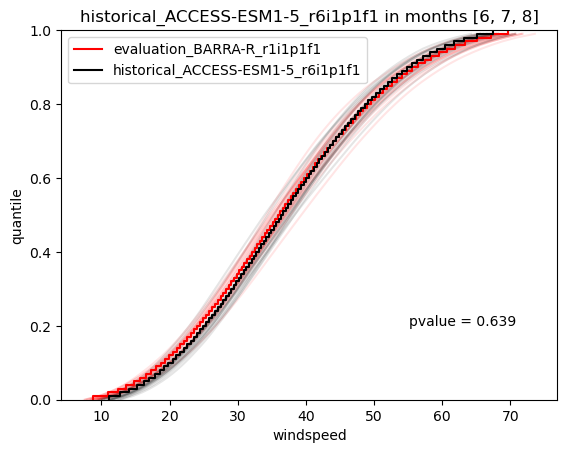

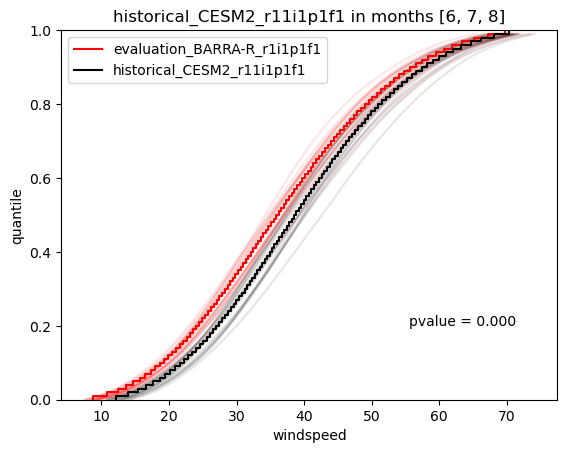

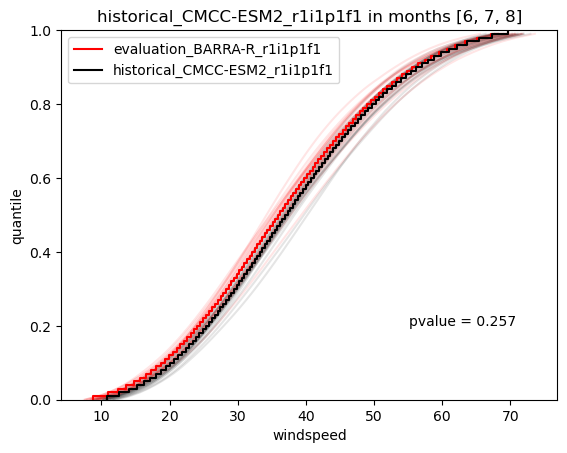

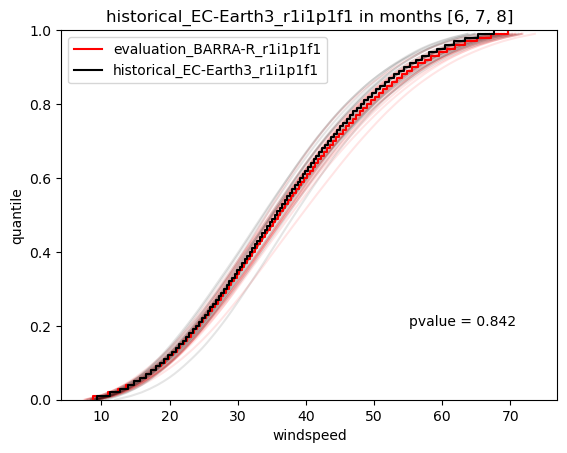

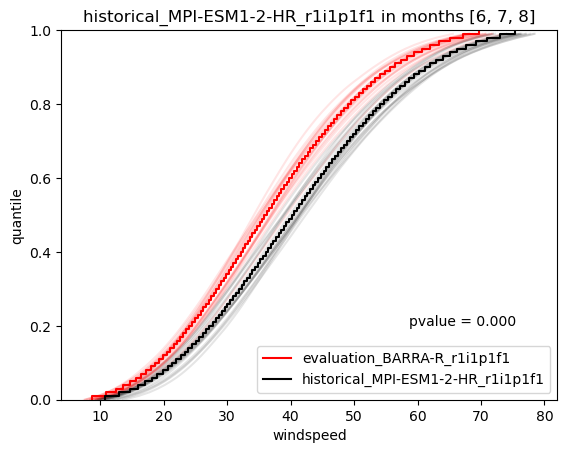

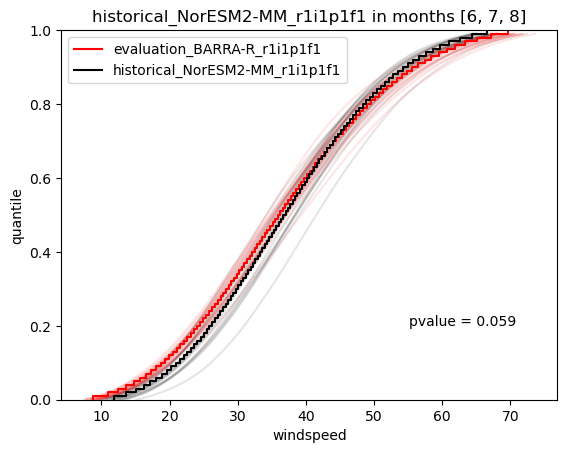

In [64]:
months = [6, 7, 8]
for run in list_historical:
    plt.figure()
    plt.title(f"{run} in months {months}")
    evaluation = list_evaluation[1]
    for year in np.arange(1990,2009):
        sns.lineplot(data = ds.sel({"run":evaluation[:24]}).where(ds.time.dt.month.isin(months),drop=True).sel({"time":f"{year}"}).mean("time"), x="windspeed", y="quantile", color="r", alpha=0.1)
    for year in np.arange(1990,2009):
        sns.lineplot(data = ds.sel({"run":run[:24]}).where(ds.time.dt.month.isin(months),drop=True).sel({"time":f"{year}"}).mean("time"), x="windspeed", y="quantile", color="k", alpha=0.1)
    sns.ecdfplot(data = ds.sel({"run":evaluation[:24]}).where(ds.time.dt.month.isin(months),drop=True).mean("time")["windspeed"], color="r", label=evaluation)
    sns.ecdfplot(data = ds.sel({"run":run[:24]}).where(ds.time.dt.month.isin(months),drop=True).mean("time")["windspeed"], color="k", label=run)
    
    # calculate pvalue
    ks_statistic, pvalue = stats.ks_2samp(ds.sel({"run":evaluation[:24]}).where(ds.time.dt.month.isin(months),drop=True).resample({"time":"YE"}).mean()["windspeed"].values.flatten(),
                                          ds.sel({"run":run[:24]}).where(ds.time.dt.month.isin(months),drop=True).resample({"time":"YE"}).mean()["windspeed"].values.flatten(),)
    # print(f"{run}: pvalue {pvalue:.3f}, ks_stat = {ks_statistic}")
    # add pvalue to plot
    plt.text(x=0.7, y=0.2, s= f"pvalue = {pvalue:.3f}", transform = plt.gca().transAxes)
    plt.legend()

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _va

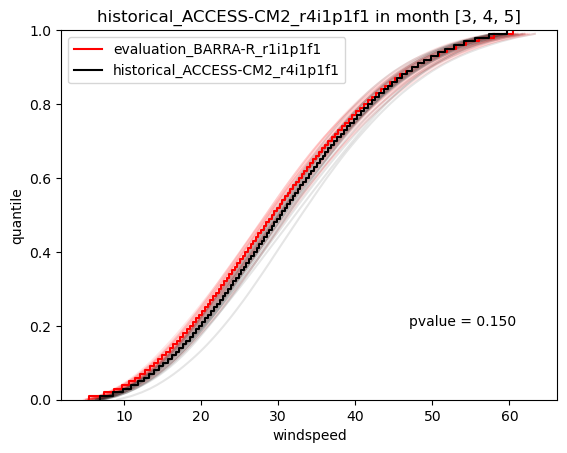

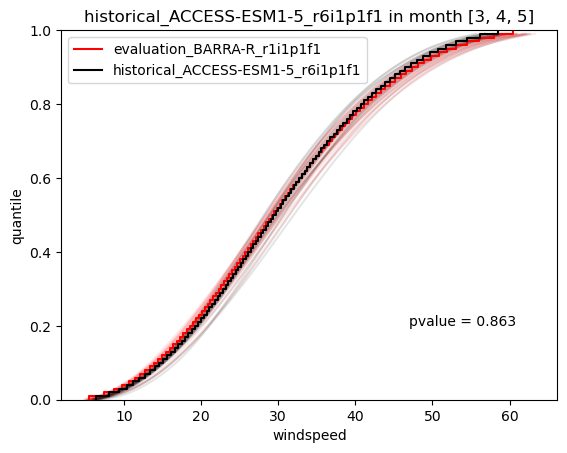

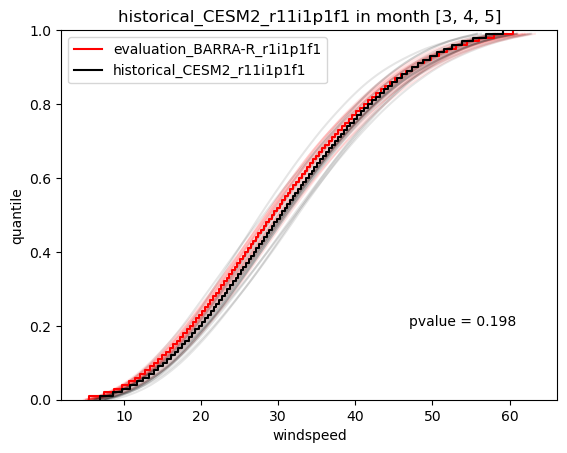

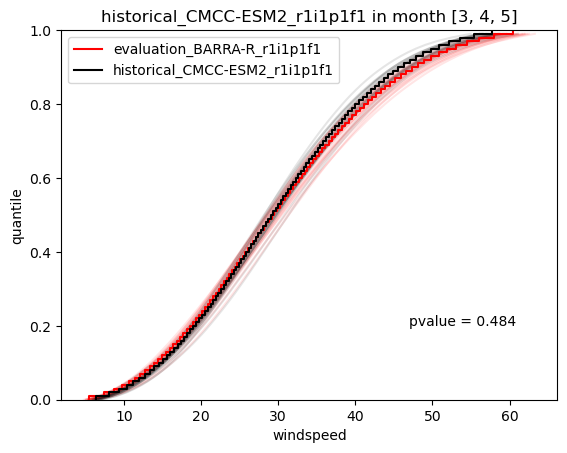

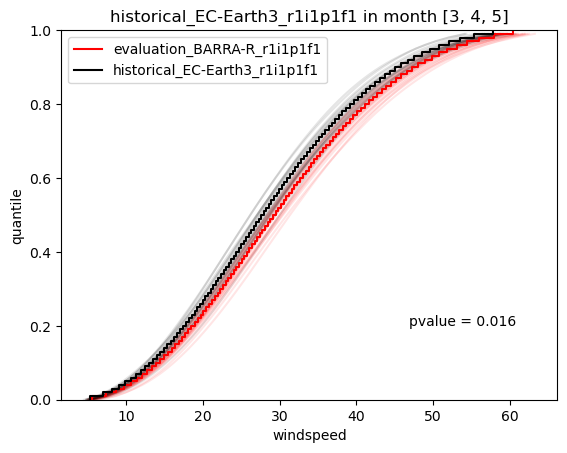

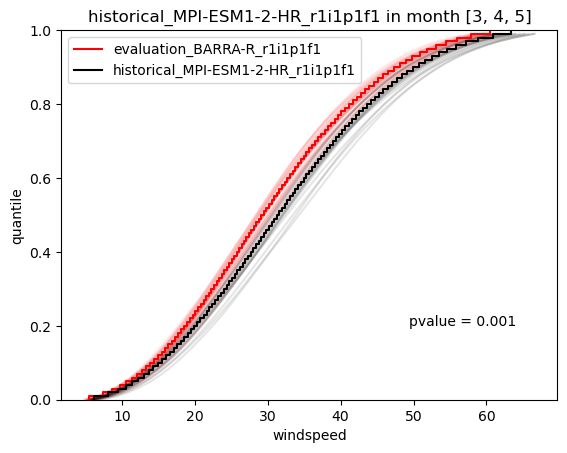

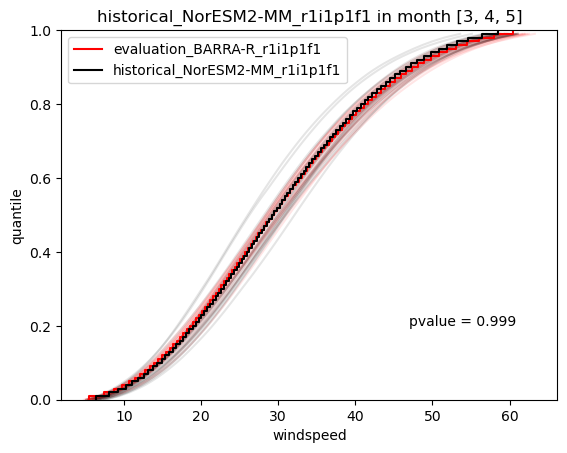

In [65]:
months = [3, 4, 5]
for run in list_historical:
    plt.figure()
    plt.title(f"{run} in month {months}")
    evaluation = list_evaluation[1]
    for year in np.arange(1990,2009):
        sns.lineplot(data = ds.sel({"run":evaluation[:24]}).where(ds.time.dt.month.isin(months),drop=True).sel({"time":f"{year}"}).mean("time"), x="windspeed", y="quantile", color="r", alpha=0.1)
    for year in np.arange(1990,2009):
        sns.lineplot(data = ds.sel({"run":run[:24]}).where(ds.time.dt.month.isin(months),drop=True).sel({"time":f"{year}"}).mean("time"), x="windspeed", y="quantile", color="k", alpha=0.1)
    sns.ecdfplot(data = ds.sel({"run":evaluation[:24]}).where(ds.time.dt.month.isin(months),drop=True).mean("time")["windspeed"], color="r", label=evaluation)
    sns.ecdfplot(data = ds.sel({"run":run[:24]}).where(ds.time.dt.month.isin(months),drop=True).mean("time")["windspeed"], color="k", label=run)
    
    # calculate pvalue
    ks_statistic, pvalue = stats.ks_2samp(ds.sel({"run":evaluation[:24]}).where(ds.time.dt.month.isin(months),drop=True).resample({"time":"YE"}).mean()["windspeed"].values.flatten(),
                                          ds.sel({"run":run[:24]}).where(ds.time.dt.month.isin(months),drop=True).resample({"time":"YE"}).mean()["windspeed"].values.flatten(),)
    # print(f"{run}: pvalue {pvalue:.3f}, ks_stat = {ks_statistic}")
    # add pvalue to plot
    plt.text(x=0.7, y=0.2, s= f"pvalue = {pvalue:.3f}", transform = plt.gca().transAxes)
    plt.legend()

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _va

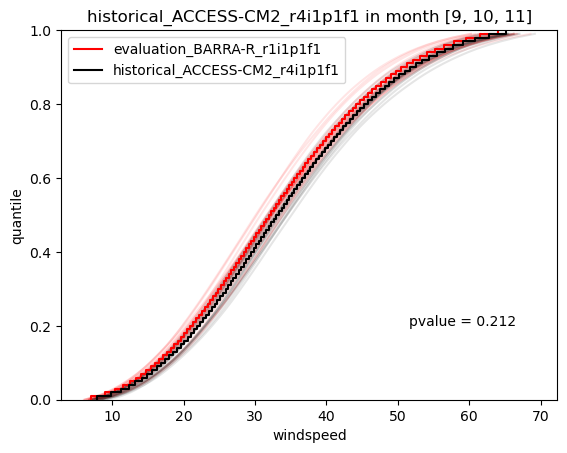

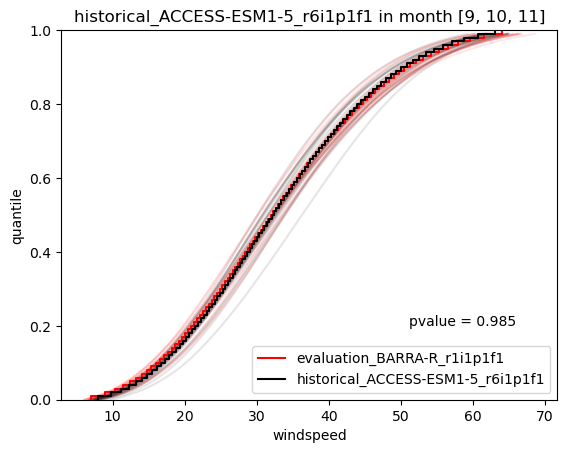

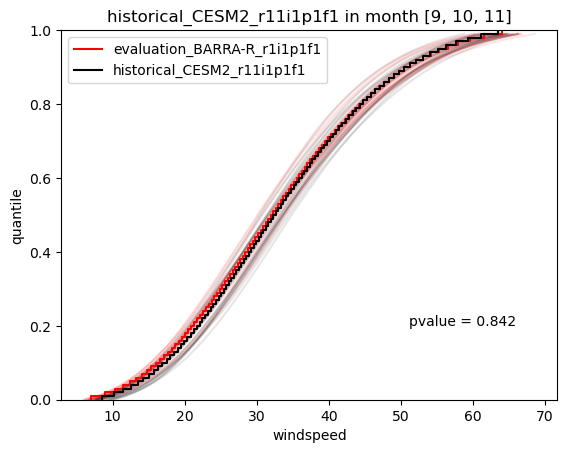

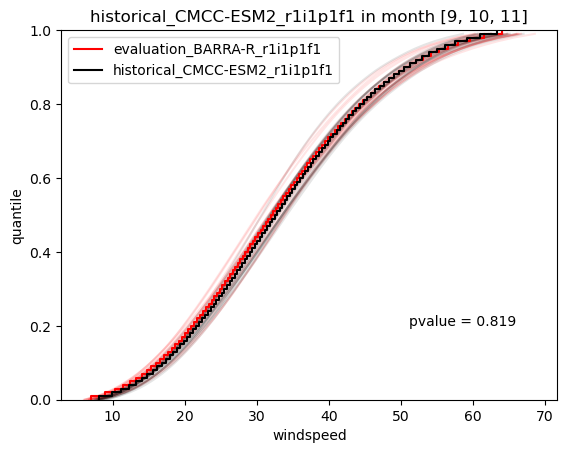

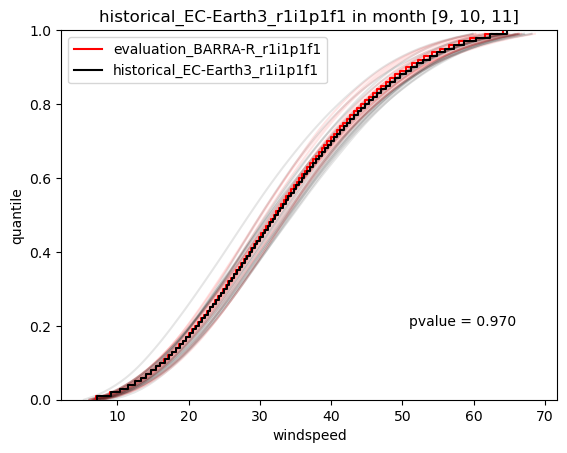

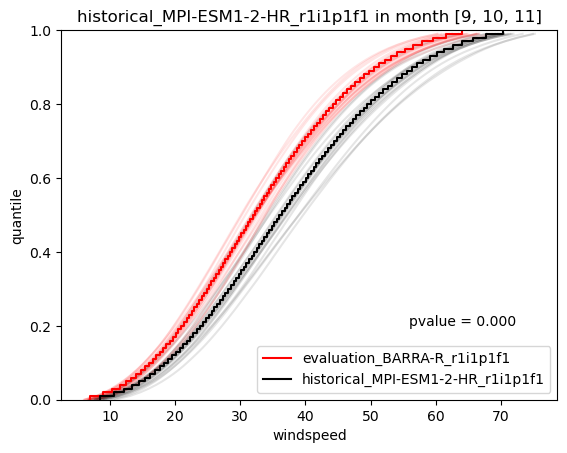

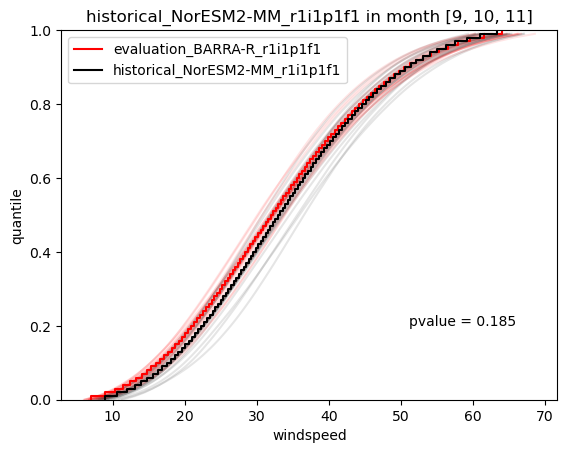

In [66]:
months = [9,10,11]
for run in list_historical:
    plt.figure()
    plt.title(f"{run} in month {months}")
    evaluation = list_evaluation[1]
    for year in np.arange(1990,2009):
        sns.lineplot(data = ds.sel({"run":evaluation[:24]}).where(ds.time.dt.month.isin(months),drop=True).sel({"time":f"{year}"}).mean("time"), x="windspeed", y="quantile", color="r", alpha=0.1)
    for year in np.arange(1990,2009):
        sns.lineplot(data = ds.sel({"run":run[:24]}).where(ds.time.dt.month.isin(months),drop=True).sel({"time":f"{year}"}).mean("time"), x="windspeed", y="quantile", color="k", alpha=0.1)
    sns.ecdfplot(data = ds.sel({"run":evaluation[:24]}).where(ds.time.dt.month.isin(months),drop=True).mean("time")["windspeed"], color="r", label=evaluation)
    sns.ecdfplot(data = ds.sel({"run":run[:24]}).where(ds.time.dt.month.isin(months),drop=True).mean("time")["windspeed"], color="k", label=run)
    
    # calculate pvalue
    ks_statistic, pvalue = stats.ks_2samp(ds.sel({"run":evaluation[:24]}).where(ds.time.dt.month.isin(months),drop=True).resample({"time":"YE"}).mean()["windspeed"].values.flatten(),
                                          ds.sel({"run":run[:24]}).where(ds.time.dt.month.isin(months),drop=True).resample({"time":"YE"}).mean()["windspeed"].values.flatten(),)
    # print(f"{run}: pvalue {pvalue:.3f}, ks_stat = {ks_statistic}")
    # add pvalue to plot
    plt.text(x=0.7, y=0.2, s= f"pvalue = {pvalue:.3f}", transform = plt.gca().transAxes)
    plt.legend()

<Axes: xlabel='windspeed', ylabel='quantile'>

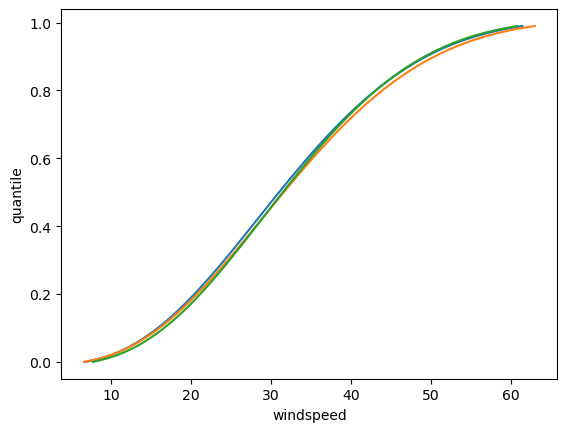

In [16]:
sns.lineplot(data = ds.sel({"run":list_evaluation[0][:24]}).mean('time'), x="windspeed", y="quantile")
sns.lineplot(data = ds.sel({"run":list_evaluation[1][:24]}).mean('time'), x="windspeed", y="quantile")

sns.lineplot(data = ds.sel({"run":list_historical[1][:24]}).mean('time'), x="windspeed", y="quantile")


<xarray.Dataset> Size: 868kB
Dimensions:    (run: 9, time: 240, quantile: 100)
Coordinates:
    pressure   int64 8B 250
  * quantile   (quantile) float64 800B 0.0 0.01 0.02 0.03 ... 0.97 0.98 0.99
  * time       (time) datetime64[ns] 2kB 1990-01-31 1990-02-28 ... 2009-12-31
  * run        (run) <U33 1kB 'evaluation_ERA5_r1i1p1f1' ... 'historical_NorE...
Data variables:
    windspeed  (run, time, quantile) float32 864kB 4.765 6.812 ... 49.22 51.08

In [6]:
%%time
turbulence_index = "windspeed"
threshold = p99

delayed_results =[]
for run in list_evaluation + list_historical:
    experiment_id, source_id, member_id = run.split("_")
    print(run)

    def _preprocess(ds, threshold=p99):
        return (ds.chunk({"time":-1, "lat":200, "lon":160})>threshold).mean(dim=["time"])

    time_range = np.arange(1990, 2009+1)
    filelist = [ f"/scratch/v46/gt3409/TMP_{turbulence_index}/TMP_{turbulence_index}_AUS-15_{source_id}_{experiment_id}_{member_id}_BOM_BARPA-R_v1-r1_6hr_{year}.nc" 
                for year in time_range]
    
    ds = xr.open_mfdataset(filelist, use_cftime=True, preprocess=_preprocess, combine="nested", concat_dim="time").assign_coords({"run":run, "time":time_range})
    delayed_results.append(ds)

results = dask.compute(delayed_results)
results

evaluation_ERA5_r1i1p1f1
evaluation_BARRA-R_r1i1p1f1
historical_ACCESS-CM2_r4i1p1f1
historical_ACCESS-ESM1-5_r6i1p1f1
historical_CESM2_r11i1p1f1
historical_CMCC-ESM2_r1i1p1f1
historical_EC-Earth3_r1i1p1f1
historical_MPI-ESM1-2-HR_r1i1p1f1
historical_NorESM2-MM_r1i1p1f1


2025-09-25 14:40:59,401 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:36883 -> tcp://127.0.0.1:34737
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/tornado/iostream.py", line 1116, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
TimeoutError: [Errno 110] Connection timed out

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/worker.py", line 1783, in get_data
    response = await comm.read(deserializers=serializers)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/comm/

CPU times: user 8min 3s, sys: 3min 12s, total: 11min 16s
Wall time: 55min 58s


([<xarray.Dataset> Size: 54MB
  Dimensions:    (time: 20, lat: 436, lon: 777)
  Coordinates:
    * lon        (lon) float64 6kB 88.04 88.19 88.34 88.5 ... 207.6 207.8 207.9
    * lat        (lat) float64 3kB -53.58 -53.42 -53.27 ... 13.32 13.48 13.63
      pressure   int64 8B 250
      run        <U24 96B 'evaluation_ERA5_r1i1p1f1'
    * time       (time) int64 160B 1990 1991 1992 1993 ... 2006 2007 2008 2009
  Data variables:
      windspeed  (time, lat, lon) float64 54MB 0.006849 0.007534 ... 0.0 0.0,
  <xarray.Dataset> Size: 54MB
  Dimensions:    (time: 20, lat: 436, lon: 777)
  Coordinates:
      pressure   int64 8B 250
    * lon        (lon) float64 6kB 88.04 88.19 88.34 88.5 ... 207.6 207.8 207.9
    * lat        (lat) float64 3kB -53.58 -53.42 -53.27 ... 13.32 13.48 13.63
      run        <U27 108B 'evaluation_BARRA-R_r1i1p1f1'
    * time       (time) int64 160B 1990 1991 1992 1993 ... 2006 2007 2008 2009
  Data variables:
      windspeed  (time, lat, lon) float64 54MB 0.0 0.0 0

In [7]:
hist_eval = xr.concat(results[0], dim=["run"])
hist_eval

ValueError: conflicting sizes for dimension 'concat_dim': length 1 on 'concat_dim' and length 9 on {'lon': 'lon', 'lat': 'lat', 'concat_dim': 'run', 'time': 'time'}

In [ ]:
xr.open_dataset("/scratch/v46/gt3409/TEMP_era5_1979-2022.nc")

In [ ]:
hist_eval

In [ ]:
hist_eval.to_netcdf("/scratch/v46/gt3409/historical_evaluation_1990-2009.nc")

In [ ]:
hist_eval = xr.open_dataset("/scratch/v46/gt3409/historical_evaluation_1990-2009.nc")#.sel(lon=slice(88.0355,196.89))
hist_eval

In [ ]:
# manual kstest
# assuming m and n are large numbers and m and n are equal
quantiles_obs = quantiles_models[var].sel({"run":list_evaluation[0]})
quantiles_model = quantiles_models[var].sel({"run":run})
D_nm = np.max(np.abs(quantiles_obs-quantiles_model)) 
p_value = 0.05
condition = np.sqrt(-np.ln(p_value/2))
D_nm > condition

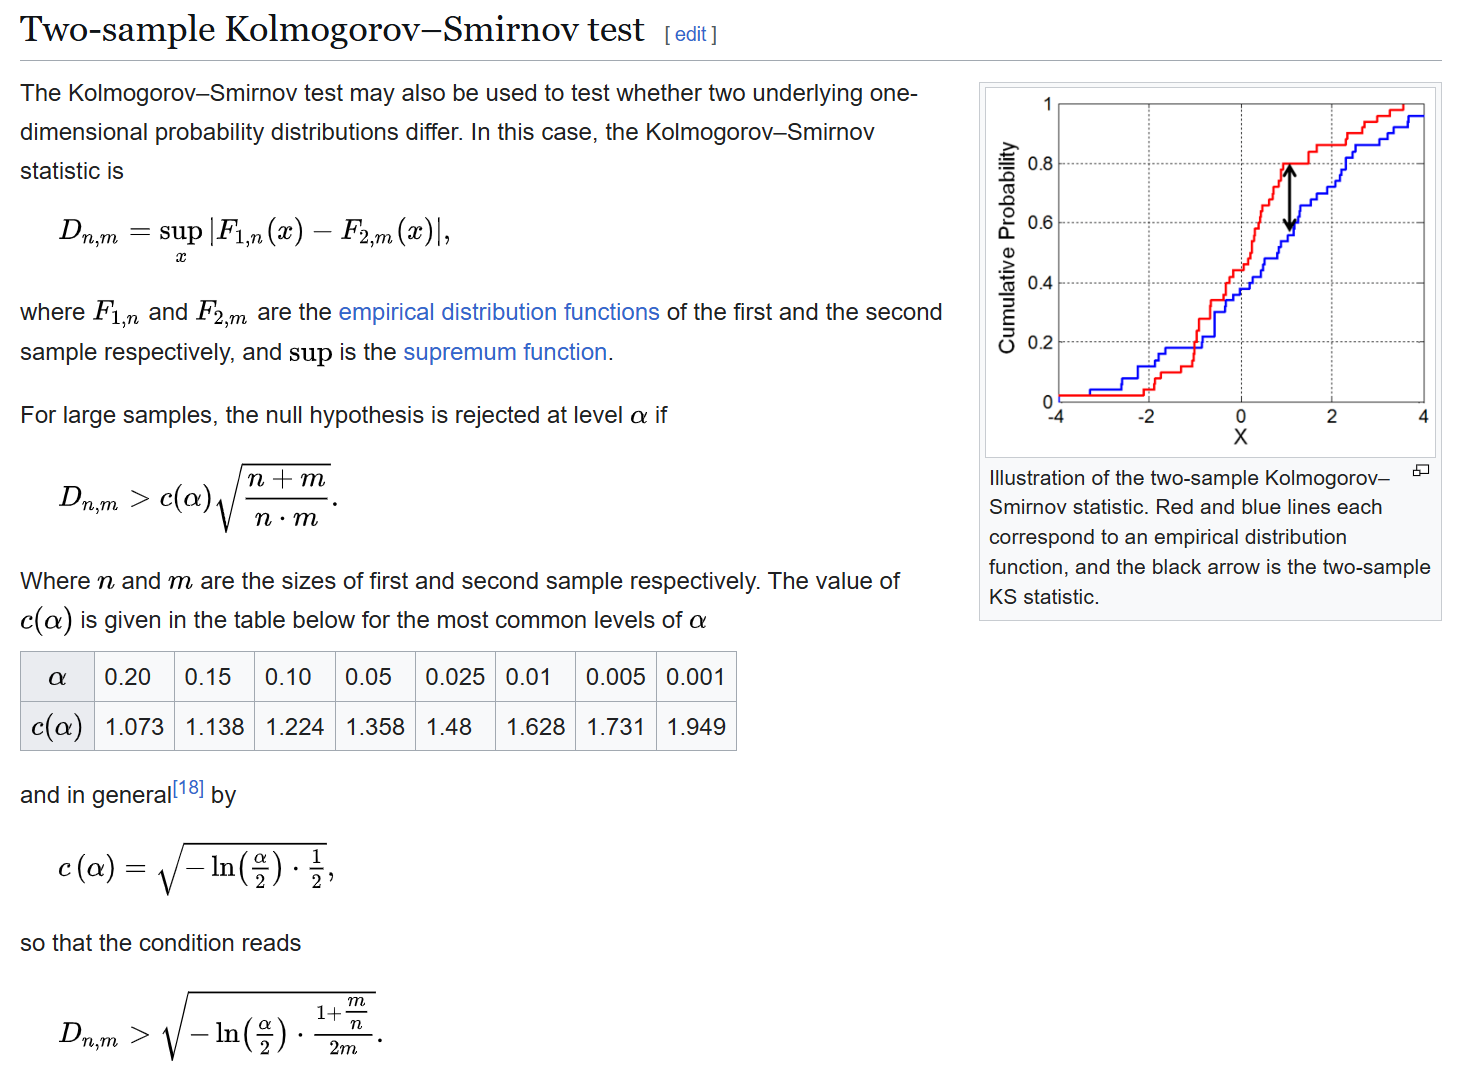

In [ ]:
def plot_model_obs_kde(model, obs, 
                       title = "", xlabel = "", var_name = "tas", ax = None):
    """Takes models and observation anomalies and calculated the pdfs using a kernel density function
    A two sided KS test is conducted to indicate if the distributions are statistically different"""
     
    sns.kdeplot(model, color="r", linestyle = "-", ax=ax, label = "model")
    sns.kdeplot(obs, color="k", linestyle = "--",  ax=ax, label = "obs").set(title = title)
    
    try:
        ax.legend(["model", "obs"])
        ax.set_xlabel(xlabel)    
    except:
        plt.legend(["model", "obs"])
        plt.xlabel(xlabel)
        
    # Calculate the pvalue for the two-sample K-S test.
    # If p is large, then the two samples are statistically indistinguishable
    _, p = stats.ks_2samp(model, obs)
    print(f"p = {p}")
            
    if p > 0.05:
        # cannot reject null hypothesis
        h="0"
    elif p <= 0.05:
        # reject null hypothesis
        h="1"
    
    try: # if a figure is already defined
        ax.text(x = 0.8, y= 0.7, s = f"h = {h}\np = {p:.3f}", transform=ax.transAxes)
    except:  
        ax = plt.sca()
        plt.text(x = 0.8, y= 0.7, s = f"h = {h}\np = {p:.3f}", transform=ax.transAxes)
    return ax, h

In [ ]:
# hist_eval = xr.open_dataset("/scratch/v46/gt3409/historical_evaluation.nc")

In [ ]:
# hist_eval

In [ ]:
era5 = hist_eval.sel(run='evaluation_ERA5_r1i1p1f1')["windspeed"].mean("time")
barra = hist_eval.sel(run='evaluation_BARRA-R_r1i1p1f1')["windspeed"].mean("time")

In [ ]:
fig, axs = plot_acs_hazard_multi(nrows=3, 
                      ncols=3, 
                      ds_list=[hist_eval.sel(run=run)["windspeed"].mean("time") 
                               for run in list_evaluation+ list_historical],
                      mask_not_australia=False,
                      ticks=np.arange(0, 0.08, 0.005),
                      tick_interval=2,
                      cbar_extend="max",
                      cbar_label="frequency of exceeding p99 windspeed",
                      figsize=(12,12),
                      title="frequency of exceeding p99 windspeed 250hPa",
                      subplot_titles=[run for run in list_evaluation+ list_historical],
                      xlim=(88.04 , 207.9),
                      ylim=(-53.58 , 13.63),
                      coastlines=True,
                      projection=ccrs.PlateCarree(130),
                      cmap=cmap_dict["ipcc_wind_seq"],
                      watermark="",
                      show_copyright=False,
                     );


In [ ]:
plot_acs_hazard_multi(nrows=3, 
                      ncols=3, 
                      ds_list=[(hist_eval.sel(run=run)["windspeed"].mean("time") - barra) 
                               for run in list_evaluation+ list_historical],
                      mask_not_australia=False,
                      ticks=np.arange(-0.05, 0.051, 0.005),
                      tick_interval=2,
                      cbar_extend="both",
                      title="Difference in frequency of exceeding p99 windspeed from BARRA-R",
                      figsize=(12,12),
                      cbar_label="frequency of exceeding p99 windspeed 250hPa",
                      subplot_titles=[run for run in list_evaluation+ list_historical],
                      xlim=(88.04 , 207.9),
                      ylim=(-53.58 , 13.63),
                      coastlines=True,
                      projection=ccrs.PlateCarree(130),
                      # cmap=cmap_dict["ipcc_wind_div"],
                      cmap=cmap_dict["anom"],
                      watermark="",
                      show_copyright=False,
                     );

In [ ]:
plot_acs_hazard_multi(nrows=3, 
                      ncols=3, 
                      ds_list=[(hist_eval.sel(run=run)["windspeed"].mean("time") - era5) 
                               for run in list_evaluation+ list_historical],
                      mask_not_australia=False,
                      ticks=np.arange(-0.05, 0.051, 0.005),
                      tick_interval=2,
                      cbar_extend="both",
                      title="Difference in frequency of exceeding p99 windspeed from ERA5",
                      figsize=(12,12),
                      cbar_label="frequency of exceeding p99 windspeed 250hPa",
                      subplot_titles=[run for run in list_evaluation+ list_historical],
                      xlim=(88.04 , 207.9),
                      ylim=(-53.58 , 13.63),
                      coastlines=True,
                      projection=ccrs.PlateCarree(130),
                      # cmap=cmap_dict["ipcc_wind_div"],
                      cmap=cmap_dict["anom"],
                      watermark="",
                      show_copyright=False,
                     );
                      

In [ ]:
%%time
for run in list_evaluation+ list_historical:
    plt.figure()
    ax = plt.subplot(projection=ccrs.PlateCarree(130))
    hist_eval.sel(run=run)["windspeed"].mean("time").plot(vmax=0.08, transform=ccrs.PlateCarree(), ax=ax)
    plt.title(run)
    ax.yaxis.set_visible(True)
    ax.grid()
    ax.coastlines()


In [ ]:
for run in list_evaluation+list_historical:
    plt.figure()
    ax = plt.subplot(projection=ccrs.PlateCarree(130))
    (hist_eval.sel(run=run)["windspeed"].mean("time") - barra).plot(cmap="RdBu_r", vmin=-0.05, vmax=0.05, transform=ccrs.PlateCarree(), ax=ax)
    plt.title(run)
    ax.yaxis.set_visible(True)
    ax.grid()
    ax.coastlines()

In [ ]:
for run in list_evaluation+list_historical:
    plt.figure()
    ax = plt.subplot(projection=ccrs.PlateCarree(130))
    (hist_eval.sel(run=run)["windspeed"].mean("time") - era5).plot(cmap="RdBu_r", vmin=-0.05, vmax=0.05, transform=ccrs.PlateCarree(), ax=ax)
    plt.title(run)
    ax.yaxis.set_visible(True)
    ax.grid()
    ax.coastlines()

In [ ]:
%%time
turbulence_index = "windspeed"

quantiles_models ={}
for run in list_evaluation + list_historical:
    experiment_id, source_id, member_id = run.split("_")
    print(run)

    for year in np.arange(1990,2009+1):
        # opening
        file = f"/scratch/v46/gt3409/TMP_windspeed/TMP_{turbulence_index}_AUS-15_{source_id}_{experiment_id}_{member_id}_BOM_BARPA-R_v1-r1_6hr_{year}.nc"
        ds_model = xr.open_dataset(file,).assign_coords({"run":run, "year":year})
    
        quantiles_models[f"{run}"] = dask.delayed(ds_model.quantile)(np.arange(0, 1, 0.01),)

results = dask.compute(quantiles_models,)
results

In [ ]:
quantiles_models = xr.concat([results[0][run] for run in list_evaluation + list_historical], 
                             dim="run").assign_coords({"run": list_evaluation + list_historical})
quantiles_models

In [ ]:
%%time
turbulence_index = "windspeed"
fig, axs = plt.subplots(5,2, figsize=(8,12), sharex=True, sharey=True)
i=0
for run in list_evaluation + list_historical:
    print(run)
    # if p-value is less than 0.05 then reject that model
    var = "windspeed"

    plot_model_obs_kde(quantiles_models[var].sel({"run":run}),
                       quantiles_models[var].sel({"run":list_evaluation[1]}),
                       title=f"{run}",
                       xlabel = f"ANN {var}",
                       ax = axs[i//2, i%2])
    plt.xlim(0,100)
    i+=1

In [ ]:
%%time
turbulence_index = "windspeed"
fig, axs = plt.subplots(5,2, figsize=(8,12), sharex=True, sharey=True)
i=0
for run in list_evaluation + list_historical:
    print(run)
    # if p-value is less than 0.05 then reject that model
    var = "windspeed"

    plot_model_obs_kde(quantiles_models[var].sel({"run":run}),
                       quantiles_models[var].sel({"run":list_evaluation[0]}),
                       title=f"{run}",
                       xlabel = f"ANN {var}",
                       ax = axs[i//2, i%2])
    plt.xlim(0,100)
    i+=1

In [ ]:
%%time
turbulence_index = "windspeed"
for run in list_evaluation + list_historical:
    experiment_id, source_id, member_id = run.split("_")
    print(run)

    plt.figure()
    quantiles_models[var].sel({"run":list_evaluation[0]}).plot(color="k",linestyle="--")
    quantiles_models[var].sel({"run":run}).plot(color="r")
    plt.show
    